# EDA on Data Of India General Election 2019 
Data Source: (https://www.kaggle.com/datasets/prakrutchauhan/indian-candidates-for-general-election-2019)



In [1]:
!pip install numpy

In [2]:
!pip install matplotlib

In [27]:
!pip install seaborn

In [28]:
!pip install plotly

In [40]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [5]:
df_elec = pd.read_csv("Dataset/IndianElections/LS_2.0.csv")
df_elec.head()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,CRIMINAL\nCASES,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,GENERAL\nVOTES,POSTAL\nVOTES,TOTAL\nVOTES,OVER TOTAL ELECTORS \nIN CONSTITUENCY,OVER TOTAL VOTES POLLED \nIN CONSTITUENCY,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,"Rs 30,99,414\n ~ 30 Lacs+","Rs 2,31,450\n ~ 2 Lacs+",376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,"Rs 1,84,77,888\n ~ 1 Crore+","Rs 8,47,000\n ~ 8 Lacs+",318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,"Rs 3,64,91,000\n ~ 3 Crore+","Rs 1,53,00,000\n ~ 1 Crore+",314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,"Rs 7,42,74,036\n ~ 7 Crore+","Rs 86,06,522\n ~ 86 Lacs+",644459,2416,646875,33.383823,56.464615,1937690


In [6]:
df_elec.columns

Index(['STATE', 'CONSTITUENCY', 'NAME', 'WINNER', 'PARTY', 'SYMBOL', 'GENDER',
       'CRIMINAL\nCASES', 'AGE', 'CATEGORY', 'EDUCATION', 'ASSETS',
       'LIABILITIES', 'GENERAL\nVOTES', 'POSTAL\nVOTES', 'TOTAL\nVOTES',
       'OVER TOTAL ELECTORS \nIN CONSTITUENCY',
       'OVER TOTAL VOTES POLLED \nIN CONSTITUENCY', 'TOTAL ELECTORS'],
      dtype='object')

In [7]:
#Rename columns
df_elec = df_elec.rename(columns={"CRIMINAL\nCASES": "criminal_cases", "GENERAL\nVOTES": "general_votes","POSTAL\nVOTES":"postal_votes","TOTAL\nVOTES":"total_votes"
                                 ,"OVER TOTAL ELECTORS \nIN CONSTITUENCY":"pct_over_total_electors_in_const"
                                 ,"OVER TOTAL VOTES POLLED \nIN CONSTITUENCY":"pct_over_total_vote_poll_in_const"})
df_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   STATE                              2263 non-null   object 
 1   CONSTITUENCY                       2263 non-null   object 
 2   NAME                               2263 non-null   object 
 3   WINNER                             2263 non-null   int64  
 4   PARTY                              2263 non-null   object 
 5   SYMBOL                             2018 non-null   object 
 6   GENDER                             2018 non-null   object 
 7   criminal_cases                     2018 non-null   object 
 8   AGE                                2018 non-null   float64
 9   CATEGORY                           2018 non-null   object 
 10  EDUCATION                          2018 non-null   object 
 11  ASSETS                             2018 non-null   objec

In [8]:
df_elec.isnull().sum()

STATE                                  0
CONSTITUENCY                           0
NAME                                   0
WINNER                                 0
PARTY                                  0
SYMBOL                               245
GENDER                               245
criminal_cases                       245
AGE                                  245
CATEGORY                             245
EDUCATION                            245
ASSETS                               245
LIABILITIES                          245
general_votes                          0
postal_votes                           0
total_votes                            0
pct_over_total_electors_in_const       0
pct_over_total_vote_poll_in_const      0
TOTAL ELECTORS                         0
dtype: int64

In [9]:
#understand where Symbol is not present
df_elec[df_elec.SYMBOL.isnull()==True]['NAME'].unique()

array(['NOTA'], dtype=object)

In [10]:
#This shows Symbol is NULL where there is NOTA - Let's Replace 
df_elec.loc[df_elec.NAME=='NOTA','SYMBOL'] = 'NoNoNo'

In [11]:
df_elec.loc[df_elec.NAME=='NOTA','SYMBOL']

3       NoNoNoNo
14      NoNoNoNo
39      NoNoNoNo
46      NoNoNoNo
54      NoNoNoNo
          ...   
2225    NoNoNoNo
2230    NoNoNoNo
2235    NoNoNoNo
2241    NoNoNoNo
2262    NoNoNoNo
Name: SYMBOL, Length: 245, dtype: object

In [12]:
df_elec[df_elec.NAME=='NOTA']

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
3,Telangana,ADILABAD,NOTA,0,NOTA,NoNoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13030,6,13036,0.875023,1.225214,1489790
14,Gujarat,AHMEDABAD WEST,NOTA,0,NOTA,NoNoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14580,139,14719,0.895688,1.473030,1643317
39,West Bengal,ALIPURDUARS,NOTA,0,NOTA,NoNoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21147,28,21175,1.284592,1.533114,1648383
46,Uttarakhand,ALMORA,NOTA,0,NOTA,NoNoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15311,194,15505,1.158985,2.215611,1337808
54,Andhra Pradesh,AMALAPURAM,NOTA,0,NOTA,NoNoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16427,41,16468,1.128288,1.333044,1459556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,Tamil Nadu,VIRUDHUNAGAR,NOTA,0,NOTA,NoNoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17087,205,17292,1.165028,1.607174,1484256
2230,Andhra Pradesh,VISAKHAPATNAM,NOTA,0,NOTA,NoNoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16626,20,16646,0.909966,1.342505,1829300
2235,Andhra Pradesh,VIZIANAGARAM,NOTA,0,NOTA,NoNoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29468,33,29501,1.961529,2.413302,1503980
2241,Telangana,WARANGAL,NOTA,0,NOTA,NoNoNoNo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18764,37,18801,1.127990,1.770886,1666770


In [13]:
df_elec[df_elec.NAME!='NOTA']

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,"Rs 30,99,414\n ~ 30 Lacs+","Rs 2,31,450\n ~ 2 Lacs+",376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,"Rs 1,84,77,888\n ~ 1 Crore+","Rs 8,47,000\n ~ 8 Lacs+",318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,"Rs 3,64,91,000\n ~ 3 Crore+","Rs 1,53,00,000\n ~ 1 Crore+",314057,181,314238,21.092771,29.534285,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,"Rs 7,42,74,036\n ~ 7 Crore+","Rs 86,06,522\n ~ 86 Lacs+",644459,2416,646875,33.383823,56.464615,1937690
5,Uttar Pradesh,AGRA,Manoj Kumar Soni,0,BSP,Elephant,MALE,0,47.0,SC,Post Graduate,"Rs 13,37,84,385\n ~ 13 Crore+","Rs 2,22,51,891\n ~ 2 Crore+",434199,1130,435329,22.466390,37.999125,1937690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2257,Maharashtra,YAVATMAL-WASHIM,Vaishali Sudhakar Yede,0,PHJSP,Whistle,FEMALE,0,28.0,GENERAL,10th Pass,"Rs 11,68,500\n ~ 11 Lacs+","Rs 9,000\n ~ 9 Thou+",20563,57,20620,1.076097,1.755157,1916185
2258,Maharashtra,YAVATMAL-WASHIM,Anil Jayram Rathod,0,IND,SHIP,MALE,0,43.0,GENERAL,Post Graduate,"Rs 48,90,000\n ~ 48 Lacs+","Rs 10,20,000\n ~ 10 Lacs+",14661,25,14686,0.766419,1.250060,1916185
2259,Telangana,ZAHIRABAD,B.B.PATIL,1,TRS,Car,MALE,18,63.0,GENERAL,Graduate,"Rs 1,28,78,51,556\n ~ 128 Crore+","Rs 1,15,35,000\n ~ 1 Crore+",434066,178,434244,28.975369,41.574183,1498666
2260,Telangana,ZAHIRABAD,MADAN MOHAN RAO,0,INC,Hand,MALE,0,49.0,GENERAL,Post Graduate,"Rs 90,36,63,001\n ~ 90 Crore+",Rs 0\n ~,427900,115,428015,28.559732,40.977823,1498666


In [14]:
#It seems whereever there is NOTA, Values are blank - Let's Fix them where possible
df_elec.loc[df_elec.NAME=='NOTA','GENDER'] = 'N/A'
df_elec.loc[df_elec.NAME=='NOTA','criminal_cases'] = 0
df_elec.loc[df_elec.NAME=='NOTA','AGE'] = 0
df_elec.loc[df_elec.NAME=='NOTA','CATEGORY'] = 'N/A'
df_elec.loc[df_elec.NAME=='NOTA','EDUCATION'] = 'N/A'
df_elec.loc[df_elec.NAME=='NOTA','ASSETS'] = 0
df_elec.loc[df_elec.NAME=='NOTA','LIABILITIES'] = 0
df_elec[df_elec.NAME=='NOTA']

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
3,Telangana,ADILABAD,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,13030,6,13036,0.875023,1.225214,1489790
14,Gujarat,AHMEDABAD WEST,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,14580,139,14719,0.895688,1.473030,1643317
39,West Bengal,ALIPURDUARS,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,21147,28,21175,1.284592,1.533114,1648383
46,Uttarakhand,ALMORA,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,15311,194,15505,1.158985,2.215611,1337808
54,Andhra Pradesh,AMALAPURAM,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,16427,41,16468,1.128288,1.333044,1459556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,Tamil Nadu,VIRUDHUNAGAR,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,17087,205,17292,1.165028,1.607174,1484256
2230,Andhra Pradesh,VISAKHAPATNAM,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,16626,20,16646,0.909966,1.342505,1829300
2235,Andhra Pradesh,VIZIANAGARAM,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,29468,33,29501,1.961529,2.413302,1503980
2241,Telangana,WARANGAL,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,18764,37,18801,1.127990,1.770886,1666770


In [15]:
df_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 19 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   STATE                              2263 non-null   object 
 1   CONSTITUENCY                       2263 non-null   object 
 2   NAME                               2263 non-null   object 
 3   WINNER                             2263 non-null   int64  
 4   PARTY                              2263 non-null   object 
 5   SYMBOL                             2263 non-null   object 
 6   GENDER                             2263 non-null   object 
 7   criminal_cases                     2263 non-null   object 
 8   AGE                                2263 non-null   float64
 9   CATEGORY                           2263 non-null   object 
 10  EDUCATION                          2263 non-null   object 
 11  ASSETS                             2263 non-null   objec

In [16]:
df_elec.isnull().sum()

STATE                                0
CONSTITUENCY                         0
NAME                                 0
WINNER                               0
PARTY                                0
SYMBOL                               0
GENDER                               0
criminal_cases                       0
AGE                                  0
CATEGORY                             0
EDUCATION                            0
ASSETS                               0
LIABILITIES                          0
general_votes                        0
postal_votes                         0
total_votes                          0
pct_over_total_electors_in_const     0
pct_over_total_vote_poll_in_const    0
TOTAL ELECTORS                       0
dtype: int64

In [17]:
df_elec

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,"Rs 30,99,414\n ~ 30 Lacs+","Rs 2,31,450\n ~ 2 Lacs+",376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,"Rs 1,84,77,888\n ~ 1 Crore+","Rs 8,47,000\n ~ 8 Lacs+",318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,"Rs 3,64,91,000\n ~ 3 Crore+","Rs 1,53,00,000\n ~ 1 Crore+",314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,"Rs 7,42,74,036\n ~ 7 Crore+","Rs 86,06,522\n ~ 86 Lacs+",644459,2416,646875,33.383823,56.464615,1937690
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,Maharashtra,YAVATMAL-WASHIM,Anil Jayram Rathod,0,IND,SHIP,MALE,0,43.0,GENERAL,Post Graduate,"Rs 48,90,000\n ~ 48 Lacs+","Rs 10,20,000\n ~ 10 Lacs+",14661,25,14686,0.766419,1.250060,1916185
2259,Telangana,ZAHIRABAD,B.B.PATIL,1,TRS,Car,MALE,18,63.0,GENERAL,Graduate,"Rs 1,28,78,51,556\n ~ 128 Crore+","Rs 1,15,35,000\n ~ 1 Crore+",434066,178,434244,28.975369,41.574183,1498666
2260,Telangana,ZAHIRABAD,MADAN MOHAN RAO,0,INC,Hand,MALE,0,49.0,GENERAL,Post Graduate,"Rs 90,36,63,001\n ~ 90 Crore+",Rs 0\n ~,427900,115,428015,28.559732,40.977823,1498666
2261,Telangana,ZAHIRABAD,BANALA LAXMA REDDY,0,BJP,Lotus,MALE,3,47.0,GENERAL,12th Pass,"Rs 5,85,77,327\n ~ 5 Crore+","Rs 52,50,000\n ~ 52 Lacs+",138731,216,138947,9.271379,13.302678,1498666


In [18]:
# Let's clear the Asset & Liabilities data
# Remove Rs , \n and text
# Should only contain number
# Rs 1,28,78,51,556\n ~ 128 Crore+ => 1287851556
#

def clean_data(x):
    try:
        str_temp = re.sub(r"\D","",(x.split('\n')[0].strip()))
        #You can replace non digit chars => x.split('Rs')[1].split('\n')[0].strip()).replace(',','')
        return int(str_temp)
    except:
        x = 0
        return x
    
clean_data("Rs 1,28,78,51,556\n ~ 128 Crore+")

1287851556

In [19]:
df_elec['ASSETS'] = df_elec['ASSETS'].apply((clean_data))
df_elec['LIABILITIES'] = df_elec['LIABILITIES'].apply((clean_data))
df_elec.head()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,3099414,231450,376892,482,377374,25.330684,35.468248,1489790
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,18477888,847000,318665,149,318814,21.399929,29.964370,1489790
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,36491000,15300000,314057,181,314238,21.092771,29.534285,1489790
3,Telangana,ADILABAD,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,13030,6,13036,0.875023,1.225214,1489790
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,74274036,8606522,644459,2416,646875,33.383823,56.464615,1937690


In [20]:
#Let's understand Education data
df_elec['EDUCATION'].unique()

array(['12th Pass', 'Post Graduate', 'N/A', 'Doctorate', 'Graduate',
       'Others', '10th Pass', '8th Pass', 'Graduate Professional',
       'Literate', 'Illiterate', '5th Pass', 'Not Available',
       'Post Graduate\n'], dtype=object)

In [21]:
df_elec.EDUCATION.replace({'Post Graduate\n':'Post Graduate'},inplace=True)
df_elec.EDUCATION.unique()

array(['12th Pass', 'Post Graduate', 'N/A', 'Doctorate', 'Graduate',
       'Others', '10th Pass', '8th Pass', 'Graduate Professional',
       'Literate', 'Illiterate', '5th Pass', 'Not Available'],
      dtype=object)

In [22]:
#Let's understand category data
df_elec['CATEGORY'].unique()

array(['ST', 'N/A', 'SC', 'GENERAL'], dtype=object)

In [23]:
#Lets see if we have duplicate based on State+Constituency+Party. I want to check there should be single candidate from party.
duplicate = df_elec[df_elec.duplicated(['STATE','CONSTITUENCY','PARTY'])]
duplicate
#we do have duplicates and that is because there are multiple Independent candidate (Party='IND') Which is valid scenario
#duplicate.PARTY.unique()

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS
145,Andhra Pradesh,ARUKU,NARAVA SATYAVATHI,0,IND,Bangles,FEMALE,0,37.0,ST,10th Pass,964000,0,11231,5,11236,0.774139,1.042073,1451418
180,Bihar,AURANGABAD,SANTOSH KUMAR SINHA,0,IND,Almirah,MALE,0,43.0,GENERAL,Graduate,1275000,0,15010,4,15014,0.861446,1.604970,1742883
182,Bihar,AURANGABAD,YOGENDRA RAM,0,IND,Balloon,MALE,0,58.0,SC,Literate,155000,0,11979,8,11987,0.687768,1.281389,1742883
229,Gujarat,BANASKANTHA,PUROHIT SHYAMABEN NARANBHAI,0,IND,DIAMOND,FEMALE,0,33.0,GENERAL,Graduate,2578000,2306381,11064,5,11069,0.652121,1.002864,1697384
252,Bihar,BANKA,MANOJ KUMAR SAH,0,IND,FLUTE,MALE,0,44.0,GENERAL,10th Pass,41500,0,44394,4,44398,2.612578,4.458257,1699394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,Bihar,VAISHALI,Ismohamad alias Md. Munna,0,IND,Bead Necklace,MALE,0,36.0,GENERAL,Graduate,1595000,0,21855,2,21857,1.259056,2.033680,1735983
2188,Bihar,VAISHALI,Rinkoo Devi,0,IND,Cot,FEMALE,Not Available,37.0,GENERAL,Not Available,0,0,16734,4,16738,0.964180,1.557384,1735983
2190,Bihar,VAISHALI,Pankaj Kumar,0,IND,Camera,MALE,1,46.0,GENERAL,Graduate Professional,25076000,200000,11979,2,11981,0.690157,1.114770,1735983
2218,Tamil Nadu,VILUPPURAM,ARASAN K,0,IND,Jackfruit,MALE,0,64.0,SC,Illiterate,330000,0,12778,3,12781,0.884906,1.124991,1444335


In [24]:
#Let's Add column using Group by to find Total Votes casted in constituency
df_elec["tot_vote_casted"] = df_elec.groupby(["STATE","CONSTITUENCY"])["total_votes"].transform('sum')
df_elec

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS,tot_vote_casted
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,3099414,231450,376892,482,377374,25.330684,35.468248,1489790,1023462
1,Telangana,ADILABAD,Godam Nagesh,0,TRS,Car,MALE,0,54.0,ST,Post Graduate,18477888,847000,318665,149,318814,21.399929,29.964370,1489790,1023462
2,Telangana,ADILABAD,RATHOD RAMESH,0,INC,Hand,MALE,3,52.0,ST,12th Pass,36491000,15300000,314057,181,314238,21.092771,29.534285,1489790,1023462
3,Telangana,ADILABAD,NOTA,0,NOTA,NoNoNoNo,N/A,0,0.0,N/A,N/A,0,0,13030,6,13036,0.875023,1.225214,1489790,1023462
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,74274036,8606522,644459,2416,646875,33.383823,56.464615,1937690,1127353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2258,Maharashtra,YAVATMAL-WASHIM,Anil Jayram Rathod,0,IND,SHIP,MALE,0,43.0,GENERAL,Post Graduate,4890000,1020000,14661,25,14686,0.766419,1.250060,1916185,1120290
2259,Telangana,ZAHIRABAD,B.B.PATIL,1,TRS,Car,MALE,18,63.0,GENERAL,Graduate,1287851556,11535000,434066,178,434244,28.975369,41.574183,1498666,1012346
2260,Telangana,ZAHIRABAD,MADAN MOHAN RAO,0,INC,Hand,MALE,0,49.0,GENERAL,Post Graduate,903663001,0,427900,115,428015,28.559732,40.977823,1498666,1012346
2261,Telangana,ZAHIRABAD,BANALA LAXMA REDDY,0,BJP,Lotus,MALE,3,47.0,GENERAL,12th Pass,58577327,5250000,138731,216,138947,9.271379,13.302678,1498666,1012346


In [25]:
df_elec.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2263 entries, 0 to 2262
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   STATE                              2263 non-null   object 
 1   CONSTITUENCY                       2263 non-null   object 
 2   NAME                               2263 non-null   object 
 3   WINNER                             2263 non-null   int64  
 4   PARTY                              2263 non-null   object 
 5   SYMBOL                             2263 non-null   object 
 6   GENDER                             2263 non-null   object 
 7   criminal_cases                     2263 non-null   object 
 8   AGE                                2263 non-null   float64
 9   CATEGORY                           2263 non-null   object 
 10  EDUCATION                          2263 non-null   object 
 11  ASSETS                             2263 non-null   int64

# I think we have good clean data now, Let's try to find some insights

In [31]:
#Lets see Education spread across State for winning candidate
winners = df_elec[df_elec['WINNER'] == 1]
winners

,STATE,CONSTITUENCY,NAME,WINNER,PARTY,SYMBOL,GENDER,criminal_cases,AGE,CATEGORY,EDUCATION,ASSETS,LIABILITIES,general_votes,postal_votes,total_votes,pct_over_total_electors_in_const,pct_over_total_vote_poll_in_const,TOTAL ELECTORS,tot_vote_casted
0,Telangana,ADILABAD,SOYAM BAPU RAO,1,BJP,Lotus,MALE,52,52.0,ST,12th Pass,3099414,231450,376892,482,377374,25.330684,35.468248,1489790,1023462
4,Uttar Pradesh,AGRA,Satyapal Singh Baghel,1,BJP,Lotus,MALE,5,58.0,SC,Doctorate,74274036,8606522,644459,2416,646875,33.383823,56.464615,1937690,1127353
7,Maharashtra,AHMADNAGAR,Dr. SUJAY RADHAKRISHNA VIKHEPATIL,1,BJP,Lotus,MALE,0,37.0,GENERAL,Doctorate,168664576,2623964,696961,7699,704660,37.856533,58.425159,1861396,1159653
10,Gujarat,AHMEDABAD EAST,Patel Hasmukhbhai Somabhai,1,BJP,Lotus,MALE,0,58.0,GENERAL,Others,74699690,6252577,745810,4024,749834,41.384970,67.005462,1811851,1065338
12,Gujarat,AHMEDABAD WEST,DR. KIRIT P. SOLANKI,1,BJP,Lotus,MALE,0,69.0,SC,Post Graduate,89474039,0,638241,3381,641622,39.044323,64.211450,1643317,986445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,Maharashtra,WARDHA,Ramdas Chandrabhanji Tadas,1,BJP,Lotus,MALE,0,65.0,GENERAL,10th Pass,65807822,8961387,575488,2876,578364,33.176713,53.918820,1743283,1042412
2247,Kerala,WAYANAD,Rahul Gandhi,1,INC,Hand,MALE,5,48.0,GENERAL,Post Graduate,158877063,7201904,705034,1333,706367,51.951012,64.640694,1359679,1059780
2250,NCT OF Delhi,WEST DELHI,PARVESH SAHIB SINGH VERMA,1,BJP,Lotus,MALE,0,41.0,GENERAL,Post Graduate,155195014,40097329,862058,3590,865648,36.499913,60.010593,2371644,1404683
2253,Maharashtra,YAVATMAL-WASHIM,Bhavana Pundlikrao Gawali,1,SHS,Bow and Arrow,FEMALE,3,46.0,GENERAL,Graduate,96873189,7396250,540104,1994,542098,28.290483,46.142912,1916185,1120290


In [60]:
import plotly.express as px
fig = px.bar(winners, x="STATE", y="criminal_cases", color='PARTY')
fig.show()

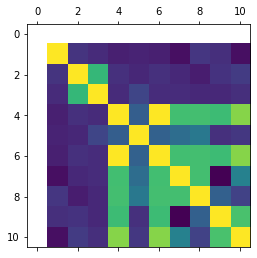